# Summary

In this notebook I extracted the subset of the MagNet data that was used to generate table III:

![image.png](attachment:image.png)

**To use it, just copy over the last cell of this notebook**

In [1]:
%run Lib.ipynb import load_material_data

Chen 2022 writes

> We use a 4-layer FNN as an example to develop a scalar-to-scalar core loss model for ferrite materials under triangular
excitations at a fixed temperature without dc bias. This particular network has one input layer, one output layer, and three
hidden layers. The input layer takes three post-processed scalar
parameters as the input variables: the fundamental frequency
f, the peak flux density B, and the duty ratio D of the
triangular waveform. The output layer has one parameter: the
magnetic core loss density of the material PV . Given the
pre-known fact that the core loss PV approximately changes
exponentially in terms of f and B, these three variables
are transformed into the logarithm values to enable a better
convergence of the network.

- Input:
    - f, Bpk, Duty Ratio (calculated from B waveform)

In [2]:
dfs = load_material_data("N87")

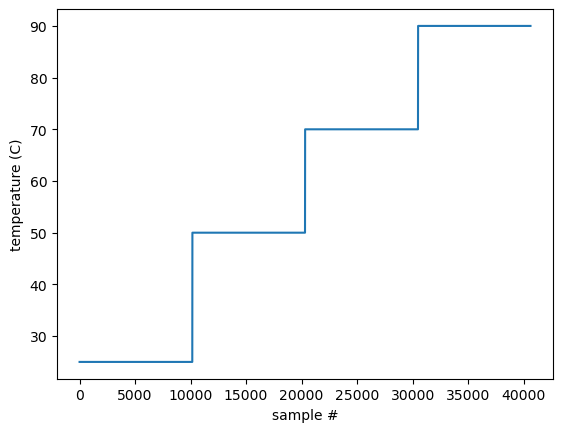

first sample above 30C: 10153


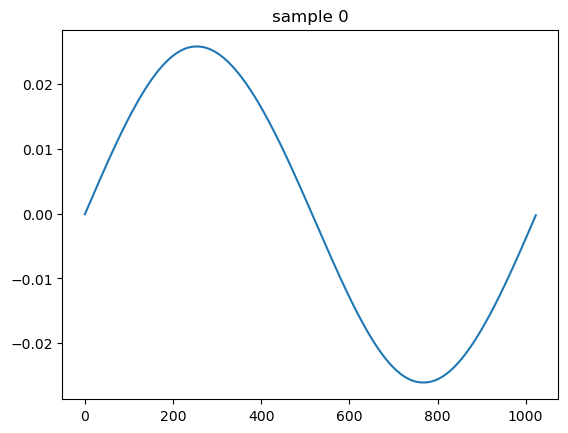

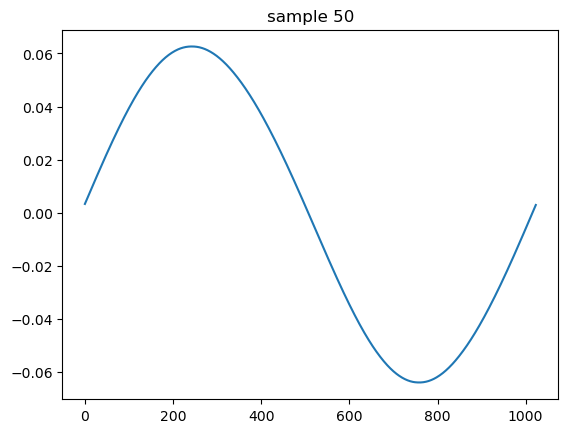

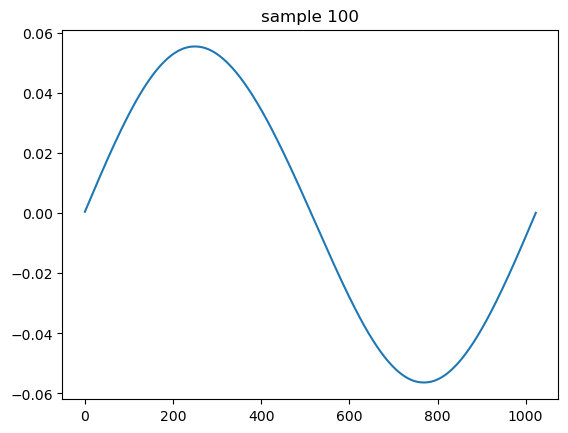

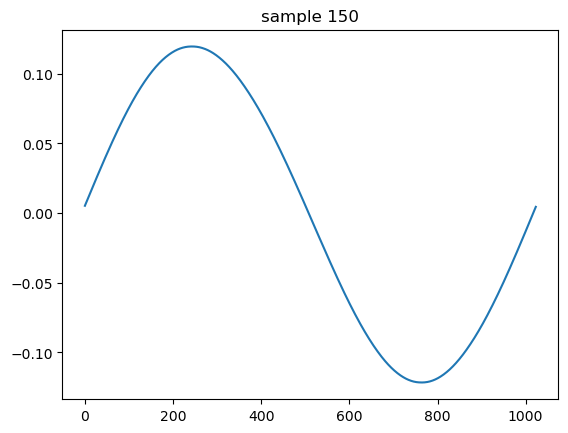

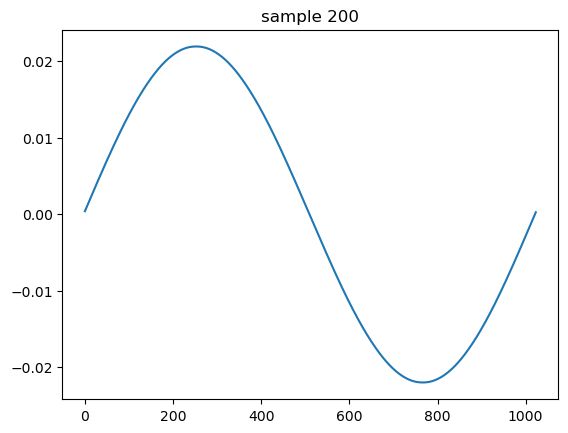

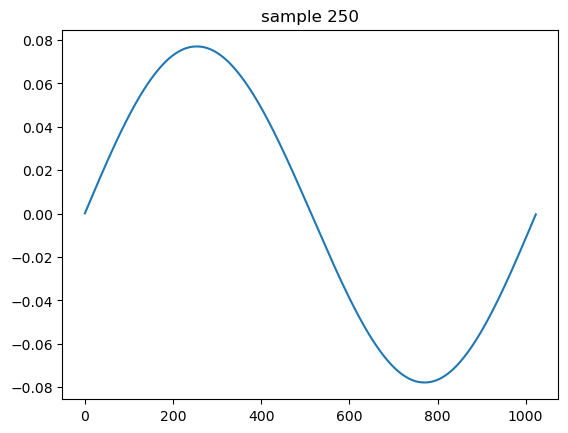

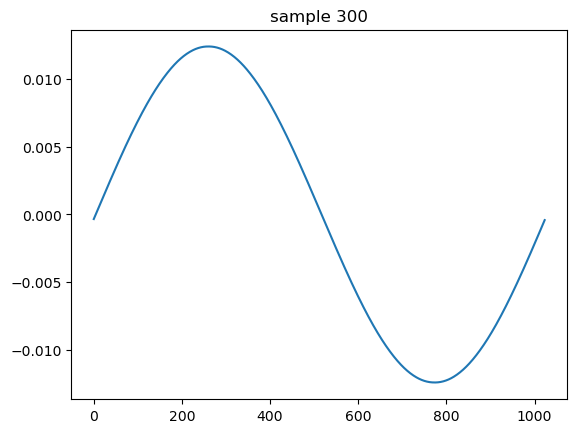

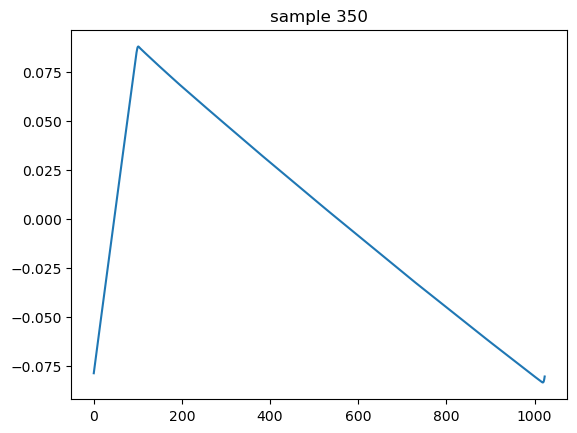

In [4]:
import matplotlib.pyplot as plt

# figure out the structure of the dataset
plt.plot(dfs["Temp"])
plt.ylabel("temperature (C)")
plt.xlabel("sample #")
plt.show()

# find the first sample where the temperature is above 30C
first_sample = (dfs["Temp"] > 30).idxmax()[0]
print(f"first sample above 30C: {first_sample}")


# 338 is the first triangular sample in the 25C subset
# 3649 is the last triangular sample in the 25C subset

# for i in range(3640, 3660):
#     plt.figure()
#     plt.plot(dfs["B"].T[int(i)], label=f"sample {i}")
#     plt.title(f"sample {i}")
# plt.show()


In [ ]:
dfs = load_material_data("N87", first_row=338, last_row=3649)

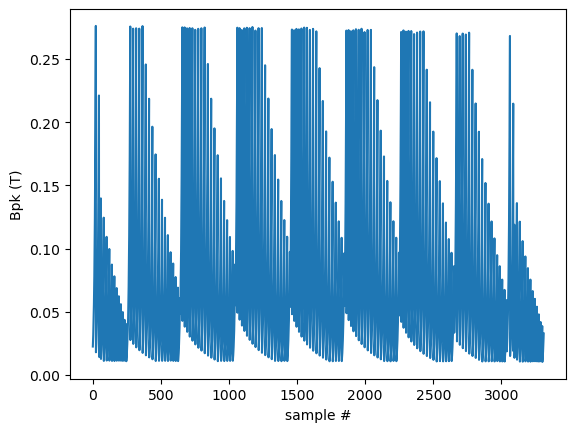

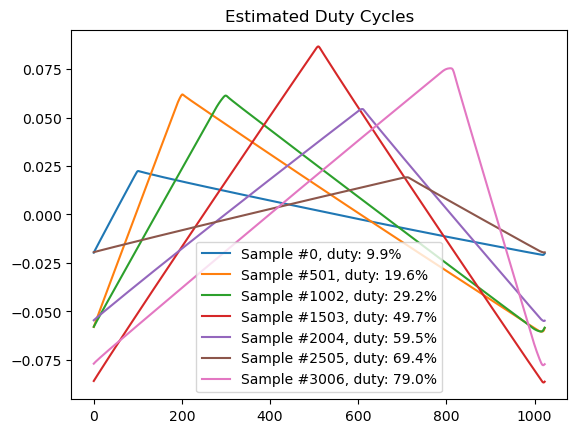

In [ ]:
dfs["Bpk"] = dfs["B"].max(axis=1)

plt.plot(dfs["Bpk"])
plt.ylabel("Bpk (T)")
plt.xlabel("sample #")
plt.show()

# extract the duty ratio from the flux waveform

def EstimateTriangleDuty(B):
    """Estimate the duty cycle of the triangle wave based on the index of the peak value"""
    Bpk = B.idxmax()
    return 100 * Bpk / len(B)

dfs["Duty"] = dfs["B"].apply(EstimateTriangleDuty, axis=1)

for i in range(0, len(dfs["B"]), 501):
    plt.plot(dfs["B"].T[int(i)], label=f"Sample #{i}, duty: {dfs['Duty'][i]:.1f}%")
plt.title(f"Estimated Duty Cycles for a few waveforms")
plt.legend()


In [ ]:
import numpy as np
X = np.column_stack(dfs["Freq"], dfs["Bpk"], dfs["Duty"])
y = dfs["Loss"]


In [ ]:
# check if running on colab
import sys
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    data_dir = '/content/drive/Shareddrives/EEE405 Group Project/MagnetChallenge/data'
else:
    data_dir = 'G:\Shared drives\EEE405 Group Project\MagnetChallenge\data'

import os
import pandas as pd
import numpy as np

def load_material_data(material, data_dir=data_dir, first_row=0, last_row=None):
    """
    Load the material data from the data directory.
    :return: dict of pandas dataframes
    """
    material_dir = os.path.join(data_dir, material + "_cycle")
    if last_row is not None:
        nrows = last_row - first_row + 1
    else:
        nrows = None

    return {
        "Freq": pd.read_csv(os.path.join(material_dir, "Frequency[Hz].csv"), nrows=nrows, header=None, skiprows=first_row),
        "Temp": pd.read_csv(os.path.join(material_dir, "Temperature[C].csv"), nrows=nrows, header=None, skiprows=first_row),
        "B": pd.read_csv(os.path.join(material_dir, "B_waveform[T].csv"), header=None, nrows=nrows, skiprows=first_row),
        "H": pd.read_csv(os.path.join(material_dir, "H_waveform[Am-1].csv"), header=None, nrows=nrows, skiprows=first_row),
        "Loss": pd.read_csv(os.path.join(material_dir, "Volumetric_losses[Wm-3].csv"), header=None, nrows=nrows, names=["Loss"], skiprows=first_row),
    }


dfs = load_material_data("N87", first_row=338, last_row=3649)
dfs["Bpk"] = dfs["B"].max(axis=1)
def EstimateTriangleDuty(B):
    """Estimate the duty cycle of the triangle wave based on the index of the peak value"""
    Bpk = B.idxmax()
    return 100 * Bpk / len(B)
dfs["Duty"] = dfs["B"].apply(EstimateTriangleDuty, axis=1)

X = np.column_stack(
    (
        np.log10(dfs["Freq"].to_numpy()),
        np.log10(dfs["Bpk"].to_numpy()),
        dfs["Duty"]
    )
)
y = np.log10(dfs["Loss"].to_numpy())
